## QBO Analysis of FMU DATA

In [2]:
from extract_fub_data import FUBDataFile
import numpy as np 
with FUBDataFile("../data/qbo.dat") as f:
    data = f.to_numpy()

data = data[~np.isnan(data[:,-1])]


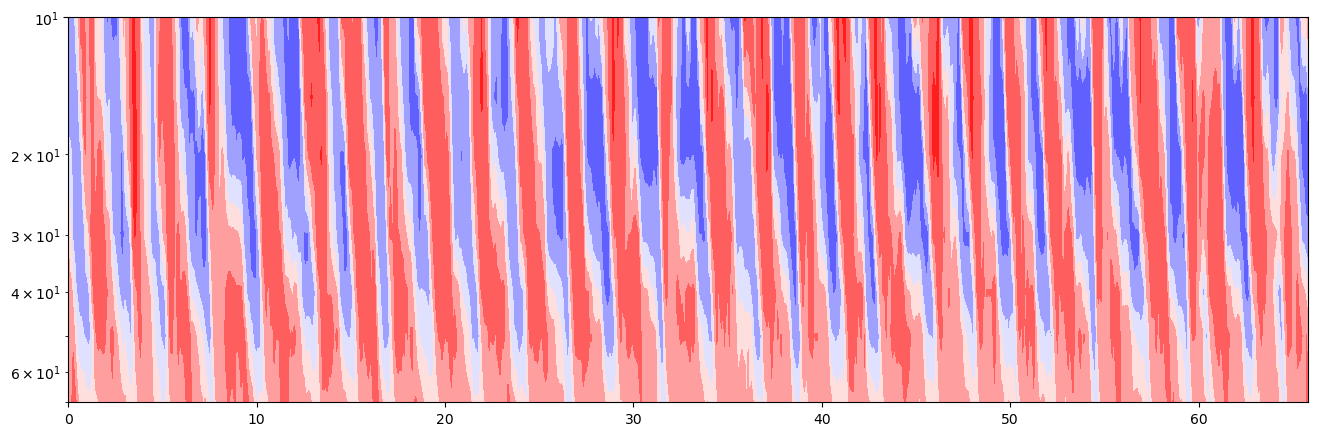

In [3]:
import matplotlib.pyplot as plt

pressures = np.array([70,50,40,30,20,15,10])

pv,tv = np.meshgrid(pressures,np.arange(data.shape[0])/12,)
fig,ax = plt.subplots(figsize=(16,5))
ax.contourf(tv,pv,data,cmap='bwr')
ax.invert_yaxis()
ax.set_yscale("log")

In [4]:
toplevel = data[:,-1]

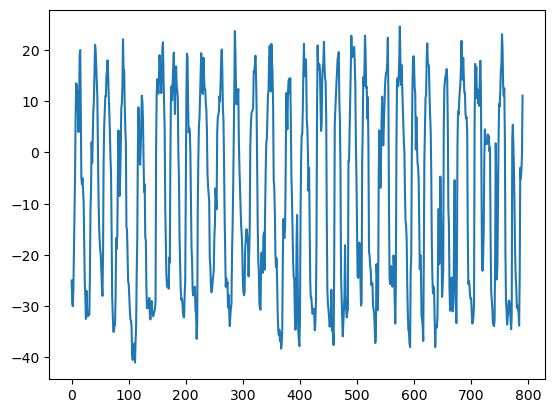

In [5]:
plt.plot(toplevel)


In [6]:
N=5
smoothed = np.convolve(toplevel,np.ones(N),mode='valid')/N

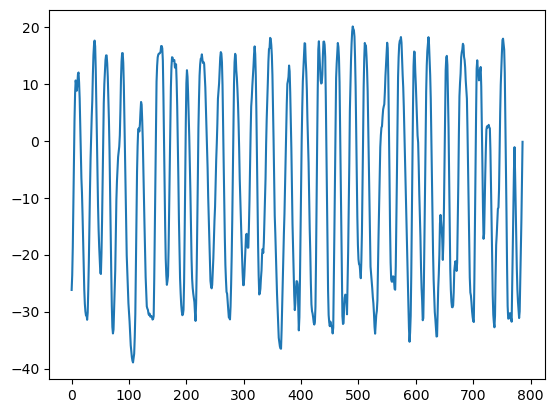

In [7]:
plt.plot(smoothed)

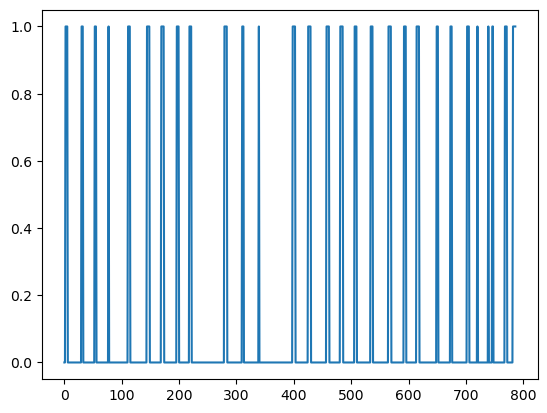

In [8]:
plt.plot(np.gradient(smoothed)>5)

In [9]:
from scipy.interpolate import InterpolatedUnivariateSpline
interp = InterpolatedUnivariateSpline(np.arange(len(smoothed)),smoothed,k=3)

In [10]:
roots = interp.roots()

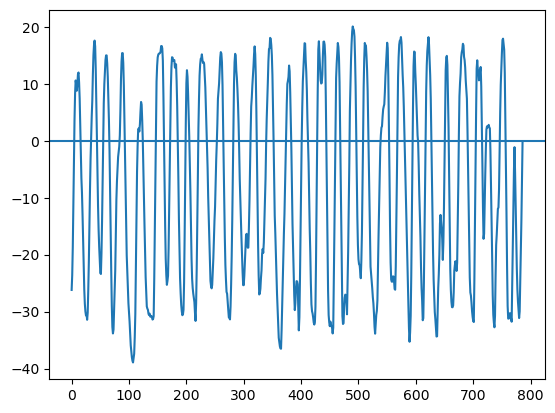

In [11]:
plt.plot(smoothed)
plt.axhline(0)

In [12]:
periods = roots[2::2] - roots[:-2:2]

In [13]:
np.mean(periods)

27.475168565819082

In [14]:
np.std(periods)

3.9921132486687365

In [15]:
from scipy.fft import fft,fftfreq
smoothed_fft = fft(smoothed - np.mean(smoothed))
freq = fftfreq(len(smoothed))
imax = np.argmax(np.abs(smoothed_fft))
imax

28

In [16]:
main_freq = freq[imax]

In [17]:
1/main_freq

28.107142857142858

In [18]:
transitions = np.round(roots).astype(int)
amplitudes = []
for (start,stop) in zip(transitions[::2],transitions[2::2]):
    max = np.max(toplevel[start:stop])
    min = np.min(toplevel[start:stop])
    amplitudes.append((max-min)/2)

In [19]:
np.mean(amplitudes)

26.68333333333334

In [20]:
np.std(amplitudes)

2.7605353748060457